In [1]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from qkeras import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns

2022-11-16 18:53:59.388902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 18:53:59.547729: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-16 18:53:59.547769: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-16 18:53:59.570392: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-16 18:54:03.808206: W tensorflow/stream_executor/platform/de

In [2]:
train_df = pd.read_csv('train_1Dx.csv',nrows=1000000)
test_df = pd.read_csv('test_1Dx.csv',nrows=500000)

In [3]:
X_train = train_df.drop(columns=['x-midplane','cotAlpha']).values
X_test = test_df.drop(columns=['x-midplane','cotAlpha']).values

y_train = train_df['x-midplane'].values
y_test = test_df['x-midplane'].values

In [4]:
# scale so that it is between 0 and 1
def scale(X):
    width = np.max(X) - np.min(X)
    return ( X-np.min(X) ) / width

In [5]:
X_train = scale(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scale(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [6]:
print(np.max(X_train),np.min(X_train))

1.0 0.0


In [7]:
def custom_loss(y, p):
    
    maxval = 1e9
    minval = 1e-9
    pi = 3.14159265359
    
    mu = tf.gather(params=p, indices=[0], axis=1)
    sigma = 0.1+tf.math.softplus(tf.gather(params=p, indices=[1], axis=1))
        
    likelihood = 1.0/tf.math.sqrt(2*pi)/sigma*tf.math.exp(-1*(y-mu)*(y-mu)/(2*sigma*sigma))
    likelihood = tf.clip_by_value(likelihood,minval,maxval)
    
    NLL = -1*tf.math.log(likelihood)
    
    return tf.keras.backend.sum(NLL,axis=1)

In [8]:
def CreateQModel(shape):
    x = x_in = Input(shape)
    #x = BatchNormalization()(x)
    x = QDense(64, 
               kernel_quantizer=quantized_bits(bits=32,
                                               integer=2, # look at the full precision model, input only quantized
                                               keep_negative=True,
                                               alpha=1
                                              ),
               bias_quantizer=quantized_bits(bits=32,
                                             integer=2, # look at the full precision model, input only quantized
                                             keep_negative=True,
                                             alpha=1
                                            ),
               name="dense1")(x)
    x = QActivation("quantized_relu(16,2)", name="relu1")(x)
    x = BatchNormalization()(x)
    x = QDense(2, 
               kernel_quantizer=quantized_bits(bits=32,
                                               integer=3, # look at the full precision model, input only quantized
                                               keep_negative=True,
                                               alpha=1
                                              ),
               bias_quantizer=quantized_bits(bits=32,
                                             integer=3, # look at the full precision model, input only quantized
                                             keep_negative=True,
                                             alpha=1
                                            ),
               name="dense2")(x)
    
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateQModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss=custom_loss)

model.summary()

2022-11-10 23:12:08.949791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-10 23:12:08.949858: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-10 23:12:08.949894: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-jennetd): /proc/driver/nvidia/version does not exist
2022-11-10 23:12:08.950501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense1 (QDense)             (None, 64)                1408      
                                                                 
 relu1 (QActivation)         (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense2 (QDense)             (None, 2)                 130       
                                                                 
Total params: 1,794
Trainable params: 1,666
Non-trainable params: 128
_________________________________________________________

In [9]:
es = EarlyStopping(patience=10,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=400, 
                    batch_size=4096,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/400
196/196 [==============================] - 4s 11ms/step - loss: 18.5646 - val_loss: 18.5375
Epoch 2/400
196/196 [==============================] - 2s 9ms/step - loss: 15.2649 - val_loss: 14.5577
Epoch 3/400
196/196 [==============================] - 2s 9ms/step - loss: 10.8410 - val_loss: 8.7819
Epoch 4/400
196/196 [==============================] - 2s 9ms/step - loss: 8.4319 - val_loss: 7.0874
Epoch 5/400
196/196 [==============================] - 2s 9ms/step - loss: 6.9634 - val_loss: 6.0872
Epoch 6/400
196/196 [==============================] - 2s 9ms/step - loss: 5.8957 - val_loss: 5.3720
Epoch 7/400
196/196 [==============================] - 2s 9ms/step - loss: 5.2063 - val_loss: 5.0143
Epoch 8/400
196/196 [==============================] - 2s 9ms/step - loss: 4.9323 - val_loss: 4.8617
Epoch 9/400
196/196 [==============================] - 2s 9ms/step - loss: 4.8101 - val_loss: 4.7673
Epoch 10/400
196/196 [==============================] - 2s 9ms/step - loss: 4.7296 - 

/tmp/ipykernel_244227/3321773974.py:10: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


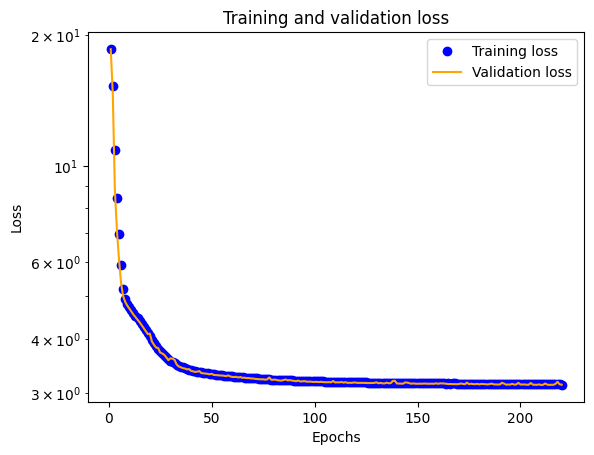

In [10]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('Log')
plt.legend()
plt.show()

In [11]:
model.save('models_1Dx/gauss32bit.keras')

In [12]:
p_test = model.predict(X_test)
df = pd.DataFrame(p_test,columns=['mu','sigma'])
df['sigma'] = 0.1 + tf.math.softplus(df['sigma'])
df['xtrue'] = y_test
df.to_csv("test_1DxGauss32bit.csv",header=False,index=False)

15625/15625 [==============================] - 21s 1ms/step


In [13]:
len(df)

500000

In [14]:
residuals = y_test - p_test[:,0]
print(np.mean(residuals),np.std(residuals))

-0.16420878353703522 6.609180912212465


In [15]:
uncertainty= 0.1 + tf.math.softplus(p_test[:,1])
print(np.mean(uncertainty),np.std(uncertainty))

5.8343024 2.4456494


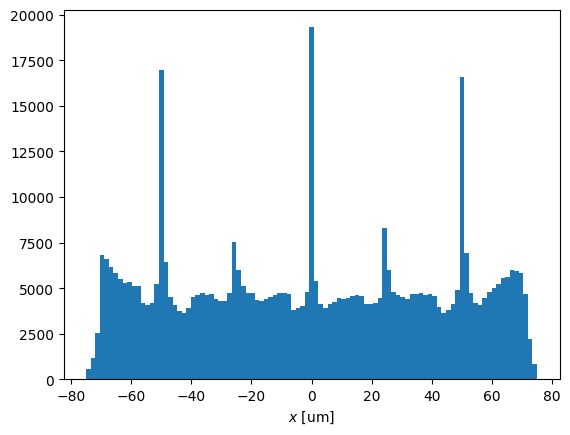

In [16]:
plt.hist(p_test[:,0],bins=np.linspace(-75,75,100))
#plt.yscale('Log')
plt.xlabel(r'$x$ [um]')
plt.show()

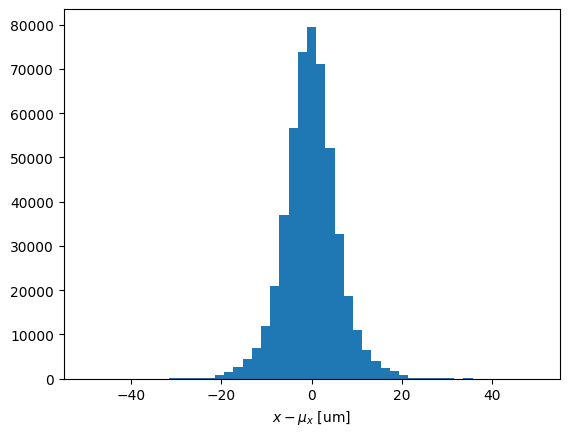

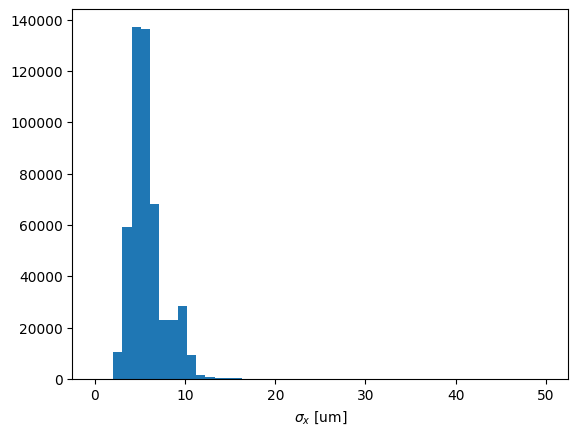

In [17]:
plt.hist(residuals,bins=np.linspace(-50,50,50))
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')
plt.show()

plt.hist(uncertainty,bins=np.linspace(0,50,50));
#plt.yscale('Log')
plt.xlabel(r'$\sigma_x$ [um]')
plt.show()

In [18]:
pulls = residuals/p_test[:,1]

Text(0.5, 0, 'pull')

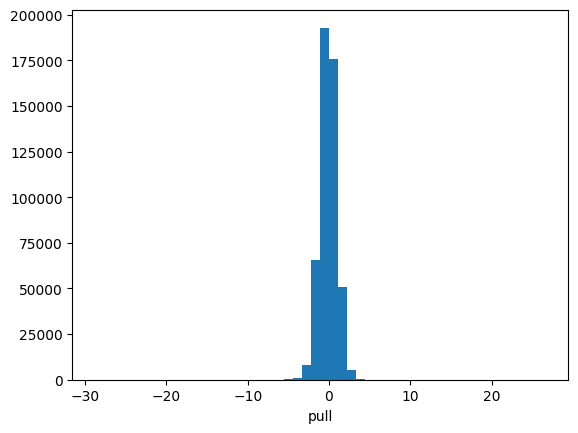

In [19]:
plt.hist(pulls,bins=50);
plt.xlabel('pull')

In [20]:
print(np.mean(pulls),np.std(pulls))

-0.037495874801310496 1.0445679049812542


In [11]:
df_1d32 = pd.read_csv('test_1DxGauss32bit.csv',header=None,names=['mu','sigma','xtrue'])
df_1d32.head()

,mu,sigma,xtrue
0,28.528229,5.614351,35.970951
1,-0.053225,4.269833,0.770363
2,-36.541424,3.367645,-37.471662
3,-16.203478,4.788179,-10.147963
4,-68.725780,4.481675,-73.204875


In [12]:
df_1d6 = pd.read_csv('test_1DxGauss6bit.csv',header=None,names=['mu','sigma','xtrue'])
df_1d6.head()

,mu,sigma,xtrue
0,24.228920,6.334222,35.970951
1,-14.046647,9.876938,0.770363
2,-45.028557,6.556015,-37.471662
3,-23.351140,7.245800,-10.147963
4,-67.072630,8.991008,-73.204875


In [13]:
df_1d5 = pd.read_csv('test_1DxGauss5bit.csv',header=None,names=['mu','sigma','xtrue'])
df_1d5.head()

,mu,sigma,xtrue
0,27.786581,12.656835,35.970951
1,-18.961416,18.669886,0.770363
2,-50.119120,12.537002,-37.471662
3,-18.778708,14.281910,-10.147963
4,-67.981810,13.486295,-73.204875


In [14]:
df_1d = pd.read_csv('test_1DxGauss.csv',header=None,names=['mu','sigma','xtrue'])
df_1d.head()

,mu,sigma,xtrue
0,28.176956,5.856075,35.970951
1,1.024220,5.268752,0.770363
2,-36.557735,3.621103,-37.471662
3,-19.406113,4.105522,-10.147963
4,-68.709490,4.445309,-73.204875


Text(0.5, 0, '$\\mu_x$ [um]')

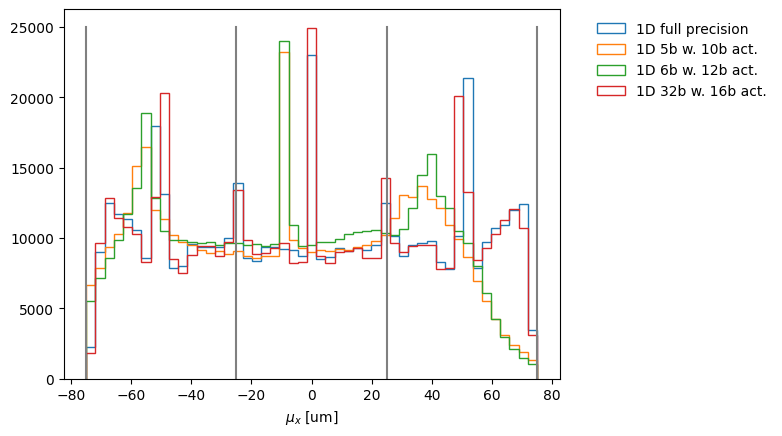

In [22]:
plt.hist(df_1d['mu'],histtype='step',bins=np.linspace(-75,75,50),label=r'1D full precision');
plt.hist(df_1d5['mu'],histtype='step',bins=np.linspace(-75,75,50),label=r'1D 5b w. 10b act.');
plt.hist(df_1d6['mu'],histtype='step',bins=np.linspace(-75,75,50),label=r'1D 6b w. 12b act.');
plt.hist(df_1d32['mu'],histtype='step',bins=np.linspace(-75,75,50),label=r'1D 32b w. 16b act.');

plt.plot([-75,-75],[0,25000],color='gray')
plt.plot([-25,-25],[0,25000],color='gray')
plt.plot([25,25],[0,25000],color='gray')
plt.plot([75,75],[0,25000],color='gray')

plt.legend(frameon=False,bbox_to_anchor=(1.05,1))
plt.xlabel(r'$\mu_x$ [um]')

Text(0.5, 0, '$\\mu_x-x$ [um]')

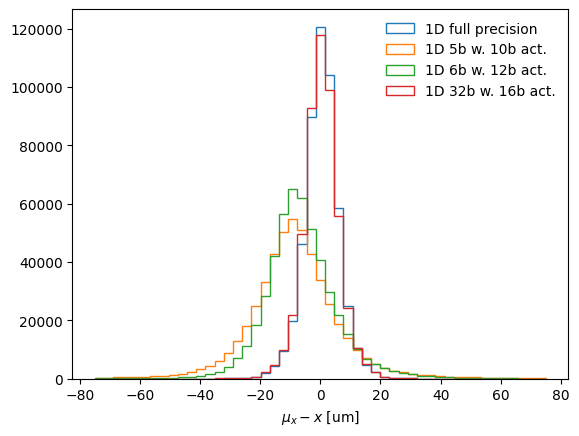

In [27]:
plt.hist(df_1d['mu']-df_1d['xtrue'],histtype='step',bins=np.linspace(-75,75,50),label=r'1D full precision');
plt.hist(df_1d5['mu']-df_1d5['xtrue'],histtype='step',bins=np.linspace(-75,75,50),label=r'1D 5b w. 10b act.');
plt.hist(df_1d6['mu']-df_1d6['xtrue'],histtype='step',bins=np.linspace(-75,75,50),label=r'1D 6b w. 12b act.');
plt.hist(df_1d32['mu']-df_1d32['xtrue'],histtype='step',bins=np.linspace(-75,75,50),label=r'1D 32b w. 16b act.');

plt.legend(frameon=False)
plt.xlabel(r'$\mu_x-x$ [um]')

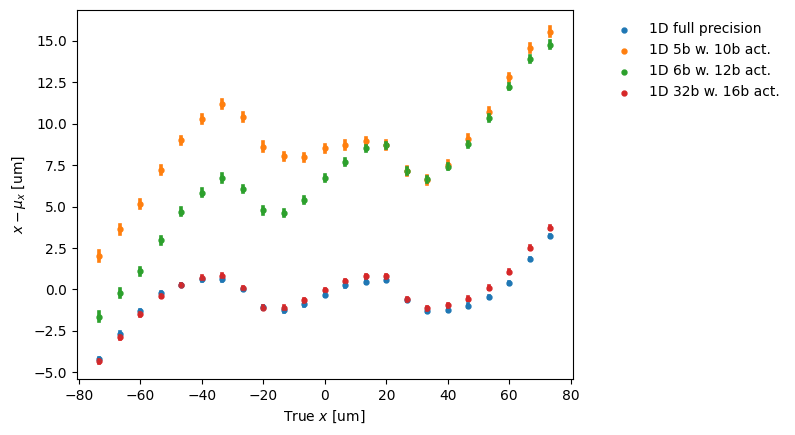

In [25]:
sns.regplot(x=df_1d['xtrue'],y=df_1d['xtrue']-df_1d['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D full precision')
sns.regplot(x=df_1d['xtrue'],y=df_1d5['xtrue']-df_1d5['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D 5b w. 10b act.')
sns.regplot(x=df_1d['xtrue'],y=df_1d6['xtrue']-df_1d6['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D 6b w. 12b act.')
sns.regplot(x=df_1d['xtrue'],y=df_1d32['xtrue']-df_1d32['mu'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D 32b w. 16b act.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')
plt.legend(frameon=False,bbox_to_anchor=(1.05,1))

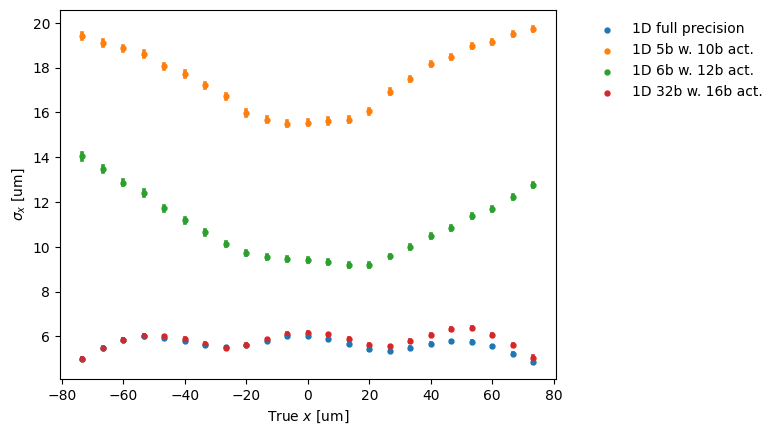

In [26]:
sns.regplot(x=df_1d['xtrue'],y=df_1d['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D full precision')
sns.regplot(x=df_1d5['xtrue'],y=df_1d5['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D 5b w. 10b act.')
sns.regplot(x=df_1d6['xtrue'],y=df_1d6['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D 6b w. 12b act.')
sns.regplot(x=df_1d32['xtrue'],y=df_1d32['sigma'], x_bins=np.linspace(-80,80,25), fit_reg=None, marker='.',label=r'1D 32b w. 16b act.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$\sigma_x$ [um]')
plt.legend(frameon=False,bbox_to_anchor=(1.05,1))

Text(0.5, 0, '$\\sigma_x$ [um]')

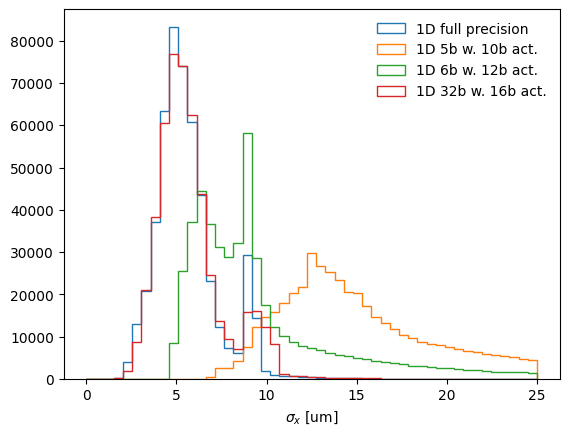

In [19]:
plt.hist(df_1d['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'1D full precision');
plt.hist(df_1d5['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'1D 5b w. 10b act.');
plt.hist(df_1d6['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'1D 6b w. 12b act.');
plt.hist(df_1d32['sigma'],histtype='step',bins=np.linspace(0,25,50),label=r'1D 32b w. 16b act.');
plt.legend(frameon=False)
plt.xlabel(r'$\sigma_x$ [um]')

In [20]:
model.layers

NameError: name 'model' is not defined

In [ ]:
max(np.array(model.layers[1].get_weights()).flatten()[0].flatten())

In [ ]:
np.max(np.array(model.layers[3].get_weights()).flatten())